# [Kaggle] Titinic 생존률 예측하기

-  1912년도 4월 15일 타이타닉호가 빙산에 충돌하여 침몰하였습니다.

-  이는 탑승한 사람들을 위한 구명보트가 충분하지 않아 승객과 승무원 2,224명 중 1,502명이 사망하였습니다

-  생존에는 어느 정도 운이 관련되어 있으나, 일부 집단 사람들은 다른 집단보다 생존 가능성이 더 높았던 것으로 추측됩니다.

-  이에 본 분석에서는 “어떤 종류의 사람들이 생존 할 가능성이 더 높은가?”라는 질문에 대한 예측모델을 구축하는 것을 목표로 합니다.

### 개요__

- 본 분석에 대한 자료는 Kaggle 에서 제공하는 **(Dataset) Titanic - Machine Learning from Disaster** 을 활용하였습니다.

- 이 자료는 탑승객의 정보를 포함하는 두 개의 유사한 데이터 세트를 다운받을 수 있습니다.
    - Train.csv : 탑승한 승객 중 891명에 대한 세부정보가 포함되며 이 탑승객에 대한 실측 진실이 공개됩니다.
    - test.csv : 탑승객 418명의 세부정보가 들어있으나 탑승객에 대한 실측 진실이 공개되지 않습니다.
    
- 따라서 위 자료 특성 및 패턴에 따라 train.csv탑승한 다른 418명의 승객의 생존여부를 예측하는 것을 중점으로 분석을 시행합니다.

### 1. Settings

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("figure", figsize = (8, 4))
sns.set_theme()

np.random.seed(2024)
np.set_printoptions(precision = 4, suppress = True)


PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 80

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [8]:
# 폰트 설정 = graph 폰트 깨짐 방지

import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt
!apt -qq install fonts-nanum
fe = fm.FontEntry(
    fname = r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name = 'NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})

'apt'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


### 2. Dataset Load

In [9]:
train = pd.read_csv("C:/sinheechan.github.io-master/Data_Analysis_Titanic/Data_Analysis_Titanic/Titanic_dataset/train.csv")
test = pd.read_csv("C:/sinheechan.github.io-master/Data_Analysis_Titanic/Data_Analysis_Titanic/Titanic_dataset/test.csv")
all_data = [train,test]

### 3. EDA

#### 3.1 Train_Data

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


#### 3.2 Test Data

In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


In [14]:
print(train.isnull().sum())
print("-"*100)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------------------------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


**[EDA 요약]**

- train.csv : 총 891개의 데이터 값과 12개의 칼럼을 보유

- test.csv : 총 418개의 데이터 값과 11개의 칼럼을 보유, train 데이터와 모든 칼럼이 같으나 survived(생존여부)에 관한 데이터 없음

### 4. 데이터 전처리

#### 4.1 불필요한 데이터 Drop

- 분석에 불필요하다고 판단되는 데이터 PassengerId, Name, Ticket 칼럼을 Drop한다.

- test 데이터에서는 PassengerId 칼럼이 없으므로 Name, Ticket 칼럼을 Drop 한다

In [15]:
train = train.drop(["PassengerId", 'Name', 'Ticket'], axis = 1 )
test = test.drop(['Name', 'Ticket'], axis= 1)

#### 4.2 결측값 대체

- Cabin : NA 값을 문자 N으로 대체한다, 전체 값을 앞글자만 딴 이름으로 변경한다.

- Age : NA 값을 평균값으로 대체한다.

- Fare : NA 값을 평균값으로 대체한다.

- Embarked : NA값을 최빈값으로 대체한다.

In [16]:
# Cabin

train['Cabin'].fillna('N', inplace=True)
train['Cabin'] = train['Cabin'].str[:1]

# Age

train['Age'].fillna(train['Age'].mean(), inplace=True)

# Fare

train["Fare"].fillna(0, inplace=True)

# Embarked

train['Embarked'].fillna(train["Embarked"].mode()[0], inplace=True)

In [17]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,N,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,N,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,N,S


### 4.3 Data Encoding

- 숫자형 값을 가지지 않은 ‘Cabin’, ‘Sex’, ‘Embarked’ 칼럼을 인코딩합니다.

In [18]:
from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])
  return dataDF

In [19]:
train = encode_features(train)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,2
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,2
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,7,2


### 5. Colums_Matplotlib

#### 5.1 Pclass

- 객실 수준이 높을수록 생존확률이 높게 나타났다.

- 이에 pclass는 추후 지도학습에서 분석해볼 만한 가치가 있다.

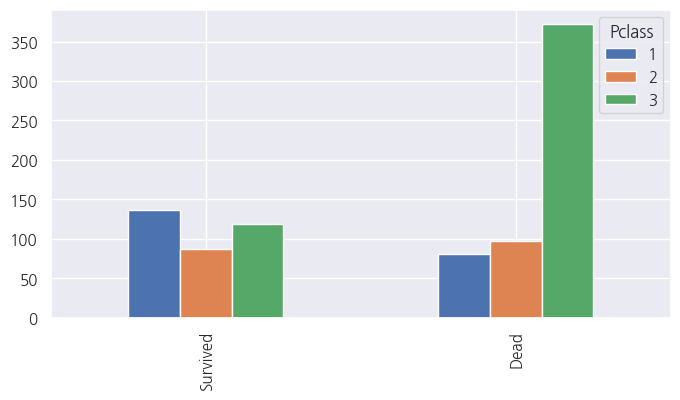

In [20]:
def bar_chart(df):
    survived = train.loc[train["Survived"] == 1, df].value_counts().sort_index()
    dead = train.loc[train["Survived"] == 0, df].value_counts().sort_index()
    data = pd.DataFrame([survived, dead], index=["Survived", "Dead"])
    setting = data.plot(kind="bar", figsize=(8, 4))
    plt.show()

bar_chart("Pclass")

#### 5.2 Fare

- 요금이 낮을수록 사망자가 높다

- 요금에 따른 사망, 생존확률이 극명하게 구분되어 분석이 필요해보인다.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


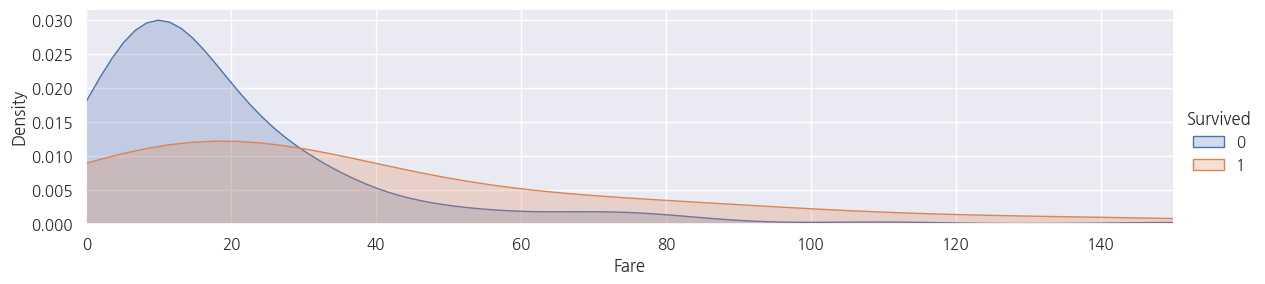

In [21]:
snake = sns.FacetGrid(train, hue="Survived", aspect=4)
snake.map(sns.kdeplot, "Fare", shade=True)
snake.set(xlim=(0, train["Fare"].max()))
snake.add_legend()
plt.xlim(0, 150)

plt.show()

#### 5.3 Sex

- 남자 = 1, 여자 = 0

- 남자보다 여자 생존자가 더 많다.

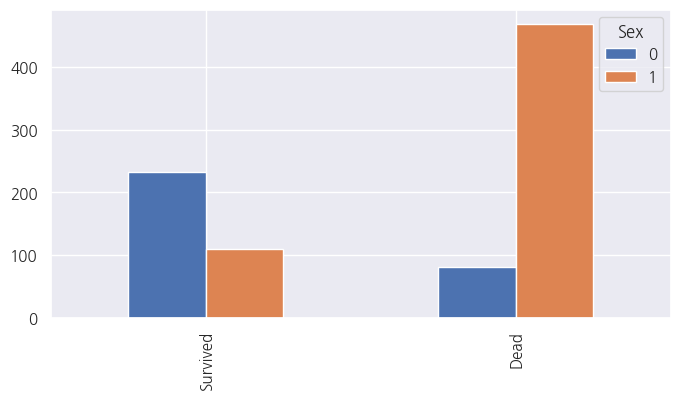

In [22]:
bar_chart('Sex')

#### 5.4 Age

- 15 ~ 35 정도의 나이까지는 생존 확률보다 사망 확률이 높다.

- 어린아이, 연장자 위주로 탈출시켰을 것으로 추측된다.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


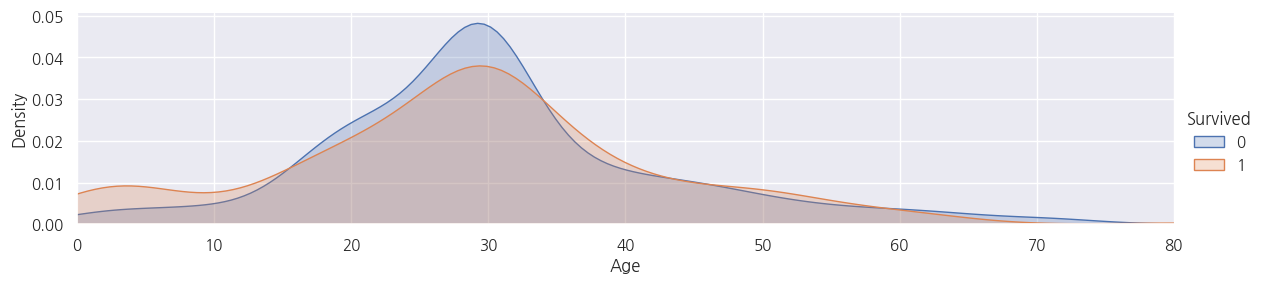

In [23]:
snake = sns.FacetGrid(train,hue='Survived',aspect=4)
snake.map(sns.kdeplot,'Age',shade=True)
snake.set(xlim=(0,train['Age'].max()))
snake.add_legend()
plt.xlim(0,80)
plt.show()

#### 5.5 sibsp(친척) + parch(가족) = Together

- 혼자 탄 경우가 사망 확률이 월등히 높다.

- 1~3인 동반자를 같이한 경우가 생존 확률이 높다.

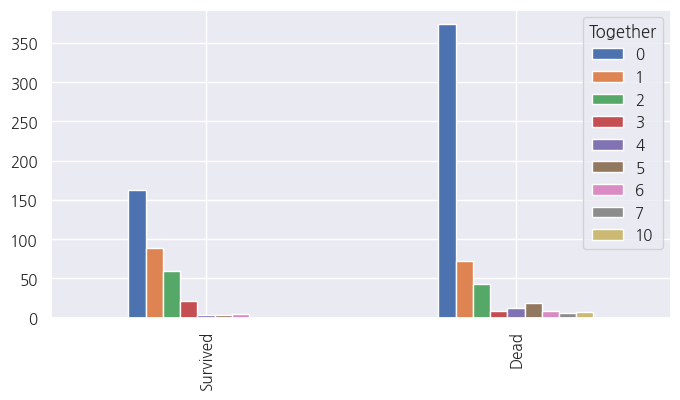

In [24]:
train['Together']= train['SibSp'] + train['Parch']
train.drop('SibSp',axis=1,inplace=True)
train.drop('Parch',axis=1,inplace=True)
bar_chart('Together')

### 6 데이터 전처리 함수화

#### 6.1 함수화

위에서 구현하였던 기능들을 Test dataset에 동일하게 적용 및 내용 요약을 목적으로 함수화한다.

- fillna : 결측값 대체 및 조정 함수

- drop_features : 불필요한 칼럼 제거함수

- format_features : 데이터 값 요약 및 인코딩 함수

- transform_features : 위 3개 함수를 모두 실행시키는 함수

- binning_features : 데이터 구간화 함수

In [25]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
  df['Cabin'].fillna('N', inplace=True)
  df['Age'].fillna(df['Age'].mean(), inplace=True) # 평균치로 결측치 채움
  df["Fare"].fillna(df["Fare"].mean(), inplace = True)
  df['Embarked'].fillna(df["Embarked"].mode()[0], inplace=True)
  print('데이터셋 null 개수:', df.isnull().sum().sum())
  return df

def drop_features(df):
  df.drop(['Name', 'Ticket'], axis=1, inplace=True) # 승객아이디보류
  return df

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

def binning_features(df):
  ranges=[0,15,25,35,60,100]
  labels=[0,1,2,3,4]
  df["AgeGroup"]=pd.cut(df['Age'],ranges,right=False,labels=labels)
  ranges=[0,15,30,100,1000]
  labels=[0,1,2,3]
  df["FareGroup"]=pd.cut(df['Fare'],ranges,right=False,labels=labels)

#### 6.2 train / test 함수 적용

In [26]:
df_train = pd.read_csv('C:/sinheechan.github.io-master/Data_analysis/Titanic_dataset/train.csv')
df_test = pd.read_csv("C:/sinheechan.github.io-master/Data_analysis/Titanic_dataset/test.csv")

X_df = df_train.drop('Survived', axis=1)
X_df = transform_features(X_df)
target = df_train['Survived']
Z_df = transform_features(df_test)

binning_features(X_df)
binning_features(Z_df)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/sinheechan.github.io-master/Data_analysis/Titanic_dataset/train.csv'

#### 6.3 train / test 데이터 셋 칼럼 일치시키기

In [105]:
X_df = X_df[["PassengerId", "Pclass", "Sex", "AgeGroup", "FareGroup"]]
Z_df = Z_df[["PassengerId", "Pclass", "Sex", "AgeGroup", "FareGroup"]]

In [106]:
X_df.head()

,PassengerId,Pclass,Sex,AgeGroup,FareGroup
0,1,3,1,1,0
1,2,1,0,3,2
2,3,3,0,2,0
3,4,1,0,3,2
4,5,3,1,3,0


In [107]:
Z_df.head()

,PassengerId,Pclass,Sex,AgeGroup,FareGroup
0,892,3,1,2,0
1,893,3,0,3,0
2,894,2,1,4,0
3,895,3,1,2,0
4,896,3,0,1,0


### 7. Machine Learning

#### 7.1 Test / Train Split 

- 비율은 8:2로 설정한다.

- X_train / X_test : 생존 칼럼을 제외한 나머지 데이터 8:2

- y_train / y_test : 생존 칼럼만 추출한 데이터 8:2

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, target, test_size=0.2, random_state=2024)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

712 712
179 179


#### 7.2 모델 정확도 측정

단순하게 각 모델 별로 정확도를 측정해본다.

[ 활용 모델 ]

- dt_clf : 의사결정나무

- rf_clf : 랜덤 포레스트

- lr_clf : 로지스틱 회귀분석

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=2024)
rf_clf = RandomForestClassifier(random_state=2024)
lr_clf = LogisticRegression(solver='liblinear')

dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LR 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DT 정확도: 0.7542
RF 정확도: 0.8156
LR 정확도: 0.7877


- RF(랜덤 포레스트) 정확도 0.81 로 가장 우수한 정확도 나타냈다.

- 하지만 아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분치 않기 때문에 어떤 알고리즘이 가장 좋은 성능인지 평가할 수는 없다.

#### 7.3 교차검증 ( K-Fold )

- 데이터 편중을 막기 위해 별도의 세트로 구성된 학습 데이터 세트와 검증 데이터 세트에서 평가 수행

- k-fold 갯수 : 5 (통상적으로 3~10 ) Fold를 가장 많이 사용한다.

In [110]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

def exec_kfold(clf, folds=5):
  kfold = KFold(n_splits=folds, shuffle = True, random_state = 42)
  scores = []

  for i, (train_index, test_index) in enumerate(kfold.split(X_df)): # K-Fold 반복
    X_train, X_test = X_df.values[train_index], X_df.values[test_index] # 8의 비율을 가진 데이터
    y_train, y_test = target.values[train_index], target.values[test_index] # 2의 비율을 가진 데이터

    clf.fit(X_train, y_train) # Classifier 학습, 예측, 정확도 계산
    prediction = clf.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    scores.append(accuracy)
    print('교차 검증{0} 정확도:{1:4f}'.format(i, accuracy))

  mean_score = np.mean(scores) # 5개 fold에서 평균 정확도 계산
  print('평균정확도:{0:4f}'.format(mean_score))

# 함수 호출
print("[dt : 의사결정나무 정확도]")
print(exec_kfold(dt_clf, folds=5))
print("-" * 50)
print("[rf : 랜덤 포레스트 정확도]")
print(exec_kfold(rf_clf, folds=5))
print("-" * 50)
print("[rl : 로지스틱 회귀분석 정확도]")
print(exec_kfold(lr_clf, folds=5))
print("-" * 50)

[dt : 의사결정나무 정확도]
교차 검증0 정확도:0.715084
교차 검증1 정확도:0.713483
교차 검증2 정확도:0.752809
교차 검증3 정확도:0.724719
교차 검증4 정확도:0.775281
평균정확도:0.736275
None
--------------------------------------------------
[rf : 랜덤 포레스트 정확도]
교차 검증0 정확도:0.793296
교차 검증1 정확도:0.758427
교차 검증2 정확도:0.786517
교차 검증3 정확도:0.752809
교차 검증4 정확도:0.786517
평균정확도:0.775513
None
--------------------------------------------------
[rl : 로지스틱 회귀분석 정확도]
교차 검증0 정확도:0.787709
교차 검증1 정확도:0.769663
교차 검증2 정확도:0.848315
교차 검증3 정확도:0.730337
교차 검증4 정확도:0.803371
평균정확도:0.787879
None
--------------------------------------------------


평균 정확도에서는 78%로 로지스틱 회귀분석이 성능이 소폭 상향 보였으나,

초기 측정값의 차이 대비 랜덤 포레스트에서 평균적으로 우수한 예측값을 보여 랜덤 포레스트로 검증 진행

#### 7.4 Cross_val_score 교차검증

- 불균형한 분포도를 가진 레이블 데이터 집합을 위한 KFold 방식

- 특정 레이블 값이 특이하게 많거나, 매우 적어서 값의 분포가 한쪽으로 치우치는 경우에 적합

- kFold와 cross_val_score의 점수가 다른 것은, cross_val_score 는 StratifiedKFold를 이용해 세트를 분할하기 때문

In [111]:
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=5, random_state=2024, shuffle=True) # shuffle 랜덤하게 데이터셋을 섞음
accs = cross_val_score(rf_clf, X_df, target, cv=cv) # model, X, y, cv
print(accs)
print('평균정확도:', np.mean(accs))

[0.8156 0.764  0.8034 0.7247 0.8034]
평균정확도: 0.7822296152156174


**[결론]**

- 모델 : 랜덤 포레스트
- K-Fold 평균 정확도 : 0.82
- Cross_val_score 평균 정확도 : 0.76

### 8 최적 파라미터 탐색

- 그리드 서치(Grid Search)를 사용하여 의사결정 트리 모델의 최적 하이퍼파라미터를 찾는다.

- 그리고 그에 대한 모델을 훈련하고 테스트 세트에서의 정확도를 출력하는 작업을 진행한다.

In [113]:
from sklearn.model_selection import GridSearchCV # 최적 하이퍼파라미터를 찾는 알고리즘

parameters = {'max_depth':[2,3,5,10], # 높을수록 모델이 복잡해지고 과적합 우려 존재
              'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]} # 높이면 덜 분할 일반화, 높이면 더 작은 리프노드, 간단해짐

grid_dclf = GridSearchCV(rf_clf, param_grid=parameters, scoring='accuracy', cv=5) # n_jobs=-1(모든 cpu 사용), verbose=2(로그출력)
grid_dclf.fit(X_train, y_train)

print('최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('최고 정확도:{0:4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

dpred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpred)
print('테스트셋 데이터의 예측 수행한 정확도:{0: 4f}'.format(accuracy))

최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
최고 정확도:0.800552
테스트셋 데이터의 예측 수행한 정확도: 0.826816


In [114]:
pred = best_dclf.predict(Z_df)
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### 9. Submmit File

PassengerId(승객 ID)와 Survived(생존 여부)  두 개의 column으로 이루어진 csv 파일 제출

- 418개의 항목과 헤더 행이 포함된 csv 파일을 제출

- test data 내에 PassengerId(승객 ID)

- test data 에 modeling을 적용하여 얻은‘Survived(생존 여부) 값

In [117]:
submission = pd.DataFrame({
"PassengerId":test['PassengerId'],
"Survived": pred
})

submission.to_csv('submission.csv',index=False)

In [119]:
submissionfile = pd.read_csv('C:/sinheechan.github.io-master/Data_analysis/submission.csv')

print(submissionfile.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


### 10. Result

- 제출 결과 : 77점

**[Feedback]**

- 보여주는 사람 입장에서 그래프와 주석을 깔끔하게 수정

- 앙상블 모델에 대한 이해 과정 후 다시 측정 필요